In [2]:
import paddle.fluid as fluid
import paddle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
def deal_data():
    # 读取文件数据，此时数据形状是(870,2)
    
    df =  pd.read_csv("./房价预测/data/data.txt",sep=',')  # 用pandas读取数据，分隔符为逗号
    housingdata = np.array(df)  # 将DF数据类型转化为numpy数据类型

    # 规范数据格式。
    housingdata = np.array(housingdata).reshape((-1, 2))  # 此时数据形状为(870,2)

    # 归一化操作
    for i in range(1):
        Max = np.max(housingdata[:, i])
        Min = np.min(housingdata[:, i])
        housingdata[:, i] = (housingdata[:, i] - Min) / (Max - Min)

    # 依据2-8原则，80%的数据作为训练数据，20%数据作为测试数据；
    Splitdata = round(len(housingdata) * 0.8)
    train_data = housingdata[:Splitdata]  # 训练数据集
    test_data = housingdata[Splitdata:]  # 测试数据集
    return train_data, test_data

Epoch   0 / iter   0, loss = 342581.5894
Epoch   0 / iter   1, loss = 455283.3876
Epoch   0 / iter   2, loss = 327978.1744
Epoch   0 / iter   3, loss = 44382721.9571
Epoch   0 / iter   4, loss = 1219024898605514.5000
Epoch   0 / iter   5, loss = 22507045196532430485370179694249377792.0000
Epoch   0 / iter   6, loss = 140994458106770890917894732279488226582959336242648569025836835123034324341470367978615104148702234673152.0000
Epoch   1 / iter   0, loss = 34405111187769251034132548186360561734344792723919748688512217728782643995379343380256294367299243298223085555503570002642779105299283624496857818690300679449028993895910170976369405191587198882290692102713787347598854092459626542811876004073845131291077604136232337181439167576479711049887533068737052672.0000
Epoch   1 / iter   1, loss = inf
Epoch   1 / iter   2, loss = nan
Epoch   1 / iter   3, loss = nan
Epoch   1 / iter   4, loss = nan
Epoch   1 / iter   5, loss = nan
Epoch   1 / iter   6, loss = nan
Epoch   2 / iter   0, loss = nan

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


Epoch  23 / iter   0, loss = nan
Epoch  23 / iter   1, loss = nan
Epoch  23 / iter   2, loss = nan
Epoch  23 / iter   3, loss = nan
Epoch  23 / iter   4, loss = nan
Epoch  23 / iter   5, loss = nan
Epoch  23 / iter   6, loss = nan
Epoch  24 / iter   0, loss = nan
Epoch  24 / iter   1, loss = nan
Epoch  24 / iter   2, loss = nan
Epoch  24 / iter   3, loss = nan
Epoch  24 / iter   4, loss = nan
Epoch  24 / iter   5, loss = nan
Epoch  24 / iter   6, loss = nan
Epoch  25 / iter   0, loss = nan
Epoch  25 / iter   1, loss = nan
Epoch  25 / iter   2, loss = nan
Epoch  25 / iter   3, loss = nan
Epoch  25 / iter   4, loss = nan
Epoch  25 / iter   5, loss = nan
Epoch  25 / iter   6, loss = nan
Epoch  26 / iter   0, loss = nan
Epoch  26 / iter   1, loss = nan
Epoch  26 / iter   2, loss = nan
Epoch  26 / iter   3, loss = nan
Epoch  26 / iter   4, loss = nan
Epoch  26 / iter   5, loss = nan
Epoch  26 / iter   6, loss = nan
Epoch  27 / iter   0, loss = nan
Epoch  27 / iter   1, loss = nan
Epoch  27 

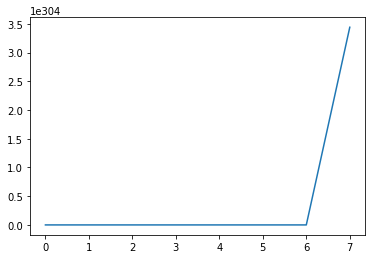

In [17]:
class Network(object):
    def __init__(self, num_net1,num_net2):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(1)
        self.w0 = np.random.randn(num_net1*num_net2,1).reshape(num_net1,num_net2)
        self.b0 = np.random.randn(num_net1,1).reshape(1,num_net1)
        self.w1 = np.random.randn(num_net2, 1)
        self.b1 = np.random.randn(1,1)
        
    def forward(self, x):
        mid = np.dot(x,self.w0) + self.b0
        z = np.dot(mid, self.w1) + self.b1
        return mid,z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost
    
    def gradient(self, x, y):
        mid,z = self.forward(x)

        gradient_w1 = np.mean((z-y) * mid, axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1 = np.mean(z-y)

        gradient_w0 = np.zeros(shape=(1,1))
        for i in range(len(x)):
            data = x[i, :]
            data = data[:, np.newaxis]
            w1 = self.w1.reshape(1, 1)
            gradient_w01 = (z - y)[i] * np.dot(data, w1)
            gradient_w0 += gradient_w01
        gradient_w0 = gradient_w0 / len(x)
        w2 = self.w1.reshape(1, 1)
        gradient_b0 = np.mean((z - y) * w2, axis=0)

        return gradient_w1, gradient_b1, gradient_w0, gradient_b0

    
    def update(self, gradient_w1, gradient_b1, gradient_w0, gradient_b0, eta):
        self.w1 = self.w1 - eta * gradient_w1
        self.b1 = self.b1 - eta * gradient_b1
        self.w0 = self.w0 - eta * gradient_w0
        self.b0 = self.b0 - eta * gradient_b0
            
                
    def train(self, training_data, num_epochs, batch_size, eta):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                _,a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w1, gradient_b1, gradient_w0, gradient_b0 = self.gradient(x, y)  # 计算梯度
                self.update(gradient_w1, gradient_b1, gradient_w0, gradient_b0, eta)  # 更新梯度
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = deal_data()

# 创建网络
net = Network(1,1)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [18]:
#加载飞桨、Numpy和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import numpy as np
import os
import random
import paddle.fluid as fluid


In [22]:
def load_data():
    # 从文件导入数据
    fname = './房价预测/data/data.txt'
    data = np.loadtxt(fname, delimiter=',',dtype='float32')
    
   
    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    feature_num = 2
    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])
    
    #  # 因为数据为一个特征所以我们需要加一个偏置作为一个恒定输入
    # a = data[:,0]
    # b = np.ones(870)/5
    # c = np.c_[a,b]
    # d = data[:,1]
    # data = np.c_[c,d]

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [23]:
class Regressor(paddle.nn.Layer):

    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义一层全连接层，输入维度是13，输出维度是1
        
        self.fc1 = Linear(in_features=1, out_features=4)
        
        self.fc2 = Linear(in_features=4, out_features=1)
    
    # 网络的前向计算
    def forward(self, inputs):
        
        middle2 = self.fc1(inputs)
        paddle.to_tensor(middle2)
        m = paddle.nn.ReLU()
        out = m(middle2)
        x = self.fc2(out)
        return x

In [24]:
# 声明定义好的线性回归模型
model = Regressor()
# 开启模型训练模式
model.train()
# 加载数据
training_data, test_data = load_data()
# 定义优化算法，使用随机梯度下降SGD
# 学习率设置为0.01
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())

In [25]:
EPOCH_NUM = 10   # 设置外层循环次数
BATCH_SIZE = 10  # 设置batch大小

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    np.random.shuffle(training_data)
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
        # 将numpy数据转为飞桨动态图tensor形式
        house_features = paddle.to_tensor(x)
        prices = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(house_features)
        
        # 计算损失
        loss = F.square_error_cost(predicts, label=prices)
        avg_loss = paddle.mean(loss)
        if iter_id%20==0:
            print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
        # 反向传播
        avg_loss.backward()
        # 最小化loss,更新参数
        opt.step()
        # 清除梯度
        opt.clear_grad()

epoch: 0, iter: 0, loss is: [0.00328743]
epoch: 0, iter: 20, loss is: [0.00305114]
epoch: 0, iter: 40, loss is: [0.00921501]
epoch: 0, iter: 60, loss is: [0.00976808]
epoch: 1, iter: 0, loss is: [0.00330687]
epoch: 1, iter: 20, loss is: [0.0036918]
epoch: 1, iter: 40, loss is: [0.01353603]
epoch: 1, iter: 60, loss is: [0.00288837]
epoch: 2, iter: 0, loss is: [0.01082382]
epoch: 2, iter: 20, loss is: [0.00586678]
epoch: 2, iter: 40, loss is: [0.00492271]
epoch: 2, iter: 60, loss is: [0.01478204]
epoch: 3, iter: 0, loss is: [0.00748355]
epoch: 3, iter: 20, loss is: [0.00942113]
epoch: 3, iter: 40, loss is: [0.00779717]
epoch: 3, iter: 60, loss is: [0.00445309]
epoch: 4, iter: 0, loss is: [0.00768874]
epoch: 4, iter: 20, loss is: [0.00486786]
epoch: 4, iter: 40, loss is: [0.02915761]
epoch: 4, iter: 60, loss is: [0.02648658]
epoch: 5, iter: 0, loss is: [0.00584669]
epoch: 5, iter: 20, loss is: [0.00319418]
epoch: 5, iter: 40, loss is: [0.00594664]
epoch: 5, iter: 60, loss is: [0.00264934]

In [26]:
# 保存模型参数，文件名为LR_model.pdparams
paddle.save(model.state_dict(), 'LR_model.pdparams')
print("模型保存成功，模型参数保存在LR_model.pdparams中")

模型保存成功，模型参数保存在LR_model.pdparams中
